In [1]:
#Import Module for Image classification
import os
import PIL

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image

import tensorflow as tf
from tensorflow import keras
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, BatchNormalization, Flatten
from keras.utils import image_dataset_from_directory
from keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam, Adagrad

#import kaggle
################################################################################################################################################
#Convert images into data-input for the model
image_size = (180,180)
batch_size = 32
train_dir = '../dataset/chest_xray/train'
test_dir = '../dataset/chest_xray/test'
val_dir = '../dataset/chest_xray/val/'

train_data = image_dataset_from_directory(
                                        train_dir,
                                        validation_split = 0.2,
                                        subset = "training",
                                        seed = 34,
                                        label_mode = "categorical",
                                        image_size = image_size,
                                        batch_size =batch_size
)

test_data = image_dataset_from_directory(
                                        test_dir,
                                        validation_split = 0.2,
                                        subset = "validation",
                                        seed = 34,
                                        label_mode = "categorical",
                                        image_size = image_size,
                                        batch_size =batch_size
)

val_data = image_dataset_from_directory(
                                        val_dir,
                                        validation_split = 0.2,
                                        subset = "validation",
                                        seed = 34,
                                        label_mode = "categorical",
                                        image_size = image_size,
                                        batch_size =batch_size
)
################################################################################################################################################
def build_model(old_model = None):
    #Building the model with transfered Learning from Resnet and weight of my prior model.
    model = Sequential()

    pre_trained_model = ResNet50(
        include_top = False,
        input_shape = (*image_size,3),
        pooling = "avg",
        classes = len(train_data.class_names),
        weights = "imagenet"
    )

    for layer in pre_trained_model.layers : 
        layer.trainable = False

    model.add(pre_trained_model)
    model.add(Flatten())
   
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.1))# To reduce the effect of Overfitting
    
    model.add(Dense(2,activation = 'sigmoid'))

    if old_model != None : #A choice to use an old model's weight or not to boost accuracy
        model_dir = '../model/' + old_model
        model.load_weights(model_dir)
    else : pass

    model.compile(optimizer=Adam(lr = 0.0001),
                    loss="binary_crossentropy",
                    metrics=['accuracy'])

    return model
################################################################################################################################################
#The weights of Model = rc_model.hdf5 for better accuracy.
my_model = build_model(old_model='rc_model.hdf5')
my_model.summary()
checkpoint_path = "../checkpoints/"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [12]:
################################################################################################################################################
# Create a callback that saves the model's weights
epoch = 10
cp_callback = [
    tf.keras.callbacks.ModelCheckpoint(checkpoint_dir + "/Checkpoint_{epoch}.keras"),    
]

# Train the model with the new callback
history = my_model.fit(train_data, 
          epochs=epoch,
          validation_data=test_data,
          callbacks=cp_callback)  # Pass callback to training
################################################################################################################################################

Epoch 1/10
131/131 [==============================] - 455s 3s/step - loss: 1.0670 - accuracy: 0.8728 - val_loss: 1.9522 - val_accuracy: 0.7339
Epoch 2/10
131/131 [==============================] - 524s 4s/step - loss: 0.7023 - accuracy: 0.9130 - val_loss: 1.6280 - val_accuracy: 0.7823
Epoch 3/10
131/131 [==============================] - 514s 4s/step - loss: 0.5133 - accuracy: 0.9281 - val_loss: 1.3280 - val_accuracy: 0.8065
Epoch 4/10
131/131 [==============================] - 486s 4s/step - loss: 0.3916 - accuracy: 0.9382 - val_loss: 1.4168 - val_accuracy: 0.7984
Epoch 5/10
131/131 [==============================] - 478s 4s/step - loss: 0.3669 - accuracy: 0.9430 - val_loss: 1.3323 - val_accuracy: 0.8145
Epoch 6/10
131/131 [==============================] - 453s 3s/step - loss: 0.2958 - accuracy: 0.9516 - val_loss: 1.2548 - val_accuracy: 0.8306
Epoch 7/10
131/131 [==============================] - 461s 4s/step - loss: 0.2429 - accuracy: 0.9573 - val_loss: 1.4327 - val_accuracy: 0.8145

In [13]:
#Save model
file_count = len(os.listdir('../model'))
new_fc=file_count + 1

my_model.save(f'../model/rc_model{new_fc}.hdf5')
################################################################################################################################################

3

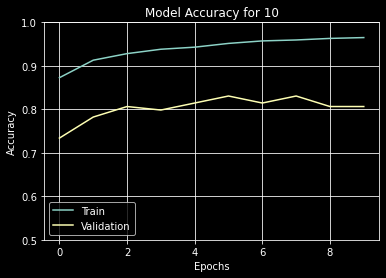

In [32]:
fig1 = plt.gcf()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(
    ymin = 0.5,
    ymax = 1
)
plt.grid()
plt.title(f'Model Accuracy for {epoch}')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'])
plt.show()



In [35]:
keras.utils.plot_model(my_model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [54]:
img = keras.preprocessing.image.load_img(val_dir+'/NORMAL/NORMAL2-IM-1431-0001.jpeg', target_size=(180,180))
img = keras.preprocessing.image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)
classes = my_model.predict(img)

score = float(classes[0][0])
print(f"This image is {100 * (1 - score):.2f}% {train_data.class_names[0]} and {100 * score:.2f}% {train_data.class_names[1]}.")

1/1 [==============================] - 0s 151ms/step
This image is 100.00% NORMAL and 0.00% PNEUMONIA.
